#**Install Spark**

In [1]:
#!pip3 -q install pyspark==3.0.3    # Problem with newer spark versions resolved, no need to install older version
!pip3 -q install pyspark

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BooleanType
from pyspark.sql.types import StringType
import re

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace

spark = SparkSession.builder \
    .appName("ReadCSVExample") \
    .getOrCreate()

#**Import Data**

In [6]:
# Flie b√¨nh lu·∫≠n
!gdown --id 15SHLILUdZ4a44oIvDTDVP35N1Kdjz8DH

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15SHLILUdZ4a44oIvDTDVP35N1Kdjz8DH
To: /content/BIGDATA_DATA_FACEBOOK.csv
100% 12.8M/12.8M [00:00<00:00, 103MB/s] 


In [4]:
# File b√¨nh lu·∫≠n
!pip install gdown
import gdown

file_url = "https://drive.google.com/uc?id=1j2GdUcs7aZx14qyQuRcfs2JXyXYWf8VJ"
output = "/content/200k_comments.csv"

# T·∫£i file v·ªÅ
gdown.download(file_url, output, quiet=False)

# ƒê·ªçc d·ªØ li·ªáu t·ª´ file CSV

csv_data = spark.read.csv(output, header=True, inferSchema=True)

csv_data.show(5, truncate=False)

Downloading...
From: https://drive.google.com/uc?id=1j2GdUcs7aZx14qyQuRcfs2JXyXYWf8VJ
To: /content/200k_comments.csv
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 38.2M/38.2M [00:00<00:00, 142MB/s]


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|comments                                                                                                                                                                    |_c1                                                    |_c2 |_c3 |_c4 |_c5 |_c6 |_c7 |_c8 |_c9 |_c10|_c11|_c12|_c13

In [5]:
# L·∫•y danh s√°ch c√°c c·ªôt
columns = csv_data.columns

In [7]:
# Danh s√°ch c√°c c·ªôt tr·ª´ c·ªôt 'comments'
columns = [col for col in csv_data.columns if col != 'comments']

# G·ªôp c√°c gi√° tr·ªã t·ª´ c√°c c·ªôt c√≤n l·∫°i v√†o c·ªôt 'comments'
from pyspark.sql.functions import concat_ws, col

csv_data = csv_data.withColumn('comments', concat_ws(' ', col('comments'), *[col(c) for c in columns]))

# Ch·ªâ gi·ªØ l·∫°i c·ªôt 'comments'
csv_data = csv_data.select('comments')
# Hi·ªÉn th·ªã m·ªôt v√†i d√≤ng c·ªßa DataFrame m·ªõi ƒë·ªÉ ki·ªÉm tra
csv_data.show(5)

+--------------------+
|            comments|
+--------------------+
|Th∆∞∆°ng ch·ªã !!!!! ...|
|  Chu·∫©n r·ªìi a tin em|
|End of season sal...|
|Ki·ªán b·∫±ng m·ªçi gi√°...|
|√∫i c√≥ anh ph√≥ng v...|
+--------------------+
only showing top 5 rows



In [8]:
# File t·ª´ toxic
!gdown --id 1bd0lAUf3EelR2GSXLAVrjbFQLuxT2R4z

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bd0lAUf3EelR2GSXLAVrjbFQLuxT2R4z
To: /content/toxicword.txt
100% 4.49k/4.49k [00:00<00:00, 13.5MB/s]


In [9]:
#ƒê·ªçc danh s√°ch t·ª´ ng·ªØ ti√™u c·ª±c t·ª´ file TXT
with open("/content/toxicword.txt", "r", encoding="utf-8") as f:
    negative_words = f.read().splitlines()

# **Tr·ª±c quan ban ƒë·∫ßu**

## Spark WordCount Demo

In [10]:
from datetime import datetime
import pytz
print('Tested on ',datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')))

!python --version
!lsb_release -a

#check which version of MongoDB  is available
#!apt-cache policy mongodb

#check which versions of software are available
!pip3 index versions pyspark
!pip3 index versions pyngrok

Tested on  2024-05-27 07:42:04.928479+07:00
Python 3.10.12
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
pyspark (3.5.1)
Available versions: 3.5.1, 3.5.0, 3.4.3, 3.4.2, 3.4.1, 3.4.0, 3.3.4, 3.3.3, 3.3.2, 3.3.1, 3.3.0, 3.2.4, 3.2.3, 3.2.2, 3.2.1, 3.2.0, 3.1.3, 3.1.2, 3.1.1, 3.0.3, 3.0.2, 3.0.1, 3.0.0, 2.4.8, 2.4.7, 2.4.6, 2.4.5, 2.4.4, 2.4.3, 2.4.2, 2.4.1, 2.4.0, 2.3.4, 2.3.3, 2.3.2, 2.3.1, 2.3.0, 2.2.3, 2.2.2, 2.2.1, 2.2.0.post0, 2.1.3, 2.1.2
  INSTALLED: 3.5.1
  LATEST:    3.5.1
pyngrok (7.1.6)
Available versions: 7.1.6, 7.1.5, 7.1.4, 7.1.3, 7.1.2, 7.1.1, 7.1.0, 7.0.5, 7.0.4, 7.0.3, 7.0.2, 7.0.1, 7.0.0, 6.1.2, 6.1.1, 6.1.0, 6.0.0, 5.2.3, 5.2.2, 5.2.1, 5.2.0, 5.1.0, 5.0.6, 5.0.5, 5.0.4, 5.0.3, 5.0.2, 5.0.1, 5.0.0, 4.2.2, 4.2.1, 4.1.16, 4.1.15, 4.1.13, 4.1.12, 4.1.11, 4.1.10, 4.1.9, 4.1.8, 4.1.7, 4.1.6, 4.1.5, 4.1.4, 4.1.3, 4.1.2, 4.1.1, 4.1.0, 4.0.3, 4.0.2, 4.0.1, 4.0.0, 3.1.1, 3.1.0, 3.0.0, 2.1.7, 2.1.6, 2.1.5, 2.1.

## Spark Installation

In [11]:
!pip3 -q install pyspark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('Praxis').getOrCreate()

from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
# note UI port switched from default 4040 to 4050 to avoid clash with ngrok

spark1 = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()

sc = spark1.sparkContext

# The spark Console UI is available in the link that will be displayed in this cell.
# If you do not wish to use the Console, you may skip the Tunnel part
sc

<SparkContext master=local[*] appName=ReadCSVExample>

## Tunnel with ngrok

In [12]:
ngrokToken = '2h086UqUHSGIUqGQmrK3MMwhOks_3jojhHutNzc9H8sWE6DVV'   # uncomment this line and place your own credentials here
#token is available at https://dashboard.ngrok.com/get-started/setup


#print(ngrokToken)
ngrokTokenCmd = 'ngrok authtoken '+ngrokToken

### ngrok - python wrapper

In [13]:
!pip3 install pyngrok

In [14]:
from pyngrok import ngrok
# you may place the token directly here
#!ngrok authtoken xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
get_ipython().system_raw(ngrokTokenCmd)

In [15]:
# Open a HTTP tunnel on the default port 80
#public_url = ngrok.connect(port = '4050')
public_url = ngrok.connect(4050)

In [16]:
#This is where the Spark Console UI will be visible
public_url

<NgrokTunnel: "https://e72c-35-221-8-101.ngrok-free.app" -> "http://localhost:4050">

## Ti·ªÅn x·ª≠ l√Ω

In [17]:
# Chuy·ªÉn ƒë·ªïi DataFrame th√†nh RDD
rdd = csv_data.rdd

In [18]:
# Chuy·ªÉn ƒë·ªïi c√°c h√†ng th√†nh chu·ªói vƒÉn b·∫£n
textRDD = rdd.map(lambda row: ",".join([str(elem) for elem in row]))

In [ ]:
textRDD.take(5)

['Th∆∞∆°ng ch·ªã !!!!! Em tin ch·ªã !!!! C·∫£m ∆°n ch·ªã !!! Ch√∫c v·ª£ ch·ªìng anh ch·ªã th·∫≠t nhi·ªÅu s·ª©c kh·ªèe !!!!! Nh·ªØng ng∆∞·ªùi ph√° ho·∫°i h·ªç s·∫Ω b·ªã tr·ª´ng ph·∫°t th√¥i. Tr·∫£ l·∫°i b√¨nh y√™n cho x√£ h·ªôi .',
 'Chu·∫©n r·ªìi a tin em',
 'End of season sale gi·∫£m 70% anh em ∆°i',
 'Ki·ªán b·∫±ng m·ªçi gi√°. Cho nh·ªØng k·∫ª vu kh·ªëng b√¥i nh·ªç danh d·ª± ng∆∞·ªùi kh√°c m·ªôt c√°ch c·∫£m t√≠nh  v√¥ cƒÉn c·ª© v√† v√¥ l∆∞∆°ng t√¢m ph·∫£i tr·∫£ gi√° ƒë√∫ng lu·∫≠t ph√°p.',
 '√∫i c√≥ anh ph√≥ng vi√™n ƒë·ªôi n√≥n Jockey th√¨ ph·∫£i']

In [19]:
import re
!pip install pyvi
from pyvi import ViTokenizer

# X√≥a ƒëi c√°c d·∫•u c√°ch th·ª´a, c√°c t·ª´ kh√¥ng c·∫ßn thi·∫øt cho vi·ªác ph√¢n lo·∫°i vƒÉn b·∫£n
def chuan_hoa_cau(textRDD):
    textRDD = re.sub(r'[^\s\w√°√†·∫£√£·∫°ƒÉ·∫Ø·∫±·∫≥·∫µ·∫∑√¢·∫•·∫ß·∫©·∫´·∫≠√©√®·∫ª·∫Ω·∫π√™·∫ø·ªÅ·ªÉ·ªÖ·ªá√≥√≤·ªè√µ·ªç√¥·ªë·ªì·ªï·ªó·ªô∆°·ªõ·ªù·ªü·ª°·ª£√≠√¨·ªâƒ©·ªã√∫√π·ªß≈©·ª•∆∞·ª©·ª´·ª≠·ªØ·ª±√Ω·ª≥·ª∑·ªπ·ªµƒë_]',' ',textRDD)
    textRDD = re.sub(r'\s+', ' ', textRDD).strip()
    return textRDD

# T√°ch t·ª´ ti·∫øng vi·ªát, t·ª´ ti·∫øng vi·ªát kh√¥ng gi·ªëng nh∆∞ ti·∫øng anh, t√°ch t·ª´ ti·∫øng anh ta ch·ªâ c·∫ßn t√°ch b·∫±ng kho·∫£ng tr·∫Øng
# Tuy nhi√™n t·ª´ ti·∫øng Vi·ªát c√≥ c·∫£ t·ª´ ƒë∆°n l·∫´n t·ª´ gh√©p n√™n t√°ch t·ª´ ti√™ng Vi·ªát s·∫Ω ph√∫c t·∫°p h∆°n
# Project s·ª≠ d·ª•ng th∆∞ vi·ªán pyvi (xem m√£ ngu·ªìn t·∫°i :https://github.com/trungtv/pyvi) ƒë·ªÉ ph·ª•c v·ª• b√†i to√°n t√°ch t·ª´ Ti·∫øng Vi·ªát
def tach_tu_tieng_viet(textRDD):
    textRDD = ViTokenizer.tokenize(textRDD)
    return textRDD

def tien_xu_li(textRDD):
    textRDD = tach_tu_tieng_viet(textRDD)
    textRDD = chuan_hoa_cau(textRDD)
    return textRDD

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.5/8.5 MB 40.3 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.1/1.1 MB 42.9 MB/s eta 0:00:00


In [20]:
textRDD2 = textRDD.map(tien_xu_li)

In [ ]:
textRDD2.take(10)

PythonRDD[25] at RDD at PythonRDD.scala:53


['Th∆∞∆°ng ch·ªã Em tin ch·ªã C·∫£m_∆°n ch·ªã Ch√∫c v·ª£_ch·ªìng anh_ch·ªã th·∫≠t nhi·ªÅu s·ª©c_kh·ªèe Nh·ªØng ng∆∞·ªùi ph√°_ho·∫°i h·ªç s·∫Ω b·ªã tr·ª´ng_ph·∫°t th√¥i Tr·∫£ l·∫°i b√¨nh_y√™n cho x√£_h·ªôi',
 'Chu·∫©n r·ªìi a tin em',
 'End of season sale gi·∫£m 70 anh_em ∆°i',
 'Ki·ªán b·∫±ng m·ªçi gi√° Cho nh·ªØng k·∫ª vu_kh·ªëng b√¥i_nh·ªç danh_d·ª± ng∆∞·ªùi kh√°c m·ªôt_c√°ch c·∫£m_t√≠nh v√¥ cƒÉn_c·ª© v√† v√¥_l∆∞∆°ng_t√¢m ph·∫£i tr·∫£_gi√° ƒë√∫ng lu·∫≠t_ph√°p',
 '√∫i c√≥ anh ph√≥ng_vi√™n ƒë·ªôi n√≥n Jockey th√¨ ph·∫£i',
 'H√∫_h√∫',
 'ƒê·ªÇ M·ªòT NG∆Ø·ªúI N√ìI TH√îI ANH CH·ªä TRANH NHAU N√ìI_KH√ì HI·ªÇU QU√ÅAAAAAAAA ANH VINH TO_TI·∫æNG QU√Å SAO L·∫†I M·∫ÆNG NG∆Ø·ªúI XEM TH·∫æ ANH ∆†I NGHE ANH N√ìI M√Ä EM S·∫ÆP KH√ìC R·ªíI',
 'Anh_ch·ªã coi live m·ªèi_m·∫Øt qua Jockey l·ª±a ƒë·ªì nhe B√™n m√¨nh ƒëang gi·∫£m 70 l·∫≠n √≥',
 'B√™n em c√≥ D·∫¶U_G·ªòI PH·ª¶ B·∫†C a Vinh mua g·ªôi cho ƒë·ª° b·∫°c t√≥c nha a Ch·ª© 2light qu√° r·ªìi',
 'X·∫øp_h√†ng kh√¥ng chen_l·∫•n c·∫£ nh√†']

### WordCount

In [21]:
from operator import add

In [22]:
def tokenize2(textRDD2):
    return textRDD2.split()

In [23]:
wordsRDD = textRDD2.flatMap(tokenize2)

In [ ]:
print(wordsRDD)
wordsRDD.take(10)

PythonRDD[27] at RDD at PythonRDD.scala:53


['Th∆∞∆°ng',
 'ch·ªã',
 'Em',
 'tin',
 'ch·ªã',
 'C·∫£m_∆°n',
 'ch·ªã',
 'Ch√∫c',
 'v·ª£_ch·ªìng',
 'anh_ch·ªã']

In [24]:
wc = wordsRDD.map(lambda x: (x,1))
counts = wc.reduceByKey(add)

In [ ]:
counts.take(10)

[('Em', 3997),
 ('C·∫£m_∆°n', 2265),
 ('Ch√∫c', 6670),
 ('v·ª£_ch·ªìng', 2573),
 ('th·∫≠t', 5865),
 ('nhi·ªÅu', 11810),
 ('s·ª©c_kh·ªèe', 3473),
 ('h·ªç', 3119),
 ('Tr·∫£', 67),
 ('x√£_h·ªôi', 467)]

In [25]:
from datetime import datetime
import pytz
print('signed off at  ',datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')))

signed off at   2024-05-27 07:42:53.265505+07:00


In [26]:
# Chuy·ªÉn ƒë·ªïi RDD th√†nh DataFrame v·ªõi schema l√† ('word', 'count')
counts_df = counts.toDF(["word", "count"])

In [ ]:
# Hi·ªÉn th·ªã DataFrame m·ªõi
counts_df.show()

+--------+-----+
|    word|count|
+--------+-----+
|      Em| 3997|
|  C·∫£m_∆°n| 2265|
|    Ch√∫c| 6670|
|v·ª£_ch·ªìng| 2573|
|    th·∫≠t| 5865|
|   nhi·ªÅu|11810|
|s·ª©c_kh·ªèe| 3473|
|      h·ªç| 3119|
|     Tr·∫£|   67|
|  x√£_h·ªôi|  467|
|      em|19585|
|     End|    1|
|      of|   27|
|    sale|  165|
|    gi·∫£m|  327|
|      70|   86|
|    b·∫±ng| 1048|
|     Cho|  877|
|   nh·ªØng| 5420|
| danh_d·ª±|   69|
+--------+-----+
only showing top 20 rows



V·∫Ω wordcloud

In [27]:
# Chuy·ªÉn ƒë·ªïi DataFrame t·ª´ PySpark sang Pandas
count_pandas_df = counts_df.toPandas()

In [28]:
# T·∫°o t·ª´ ƒëi·ªÉn t·∫ßn su·∫•t t·ª´
word_freq = dict(zip(count_pandas_df ['word'], count_pandas_df ['count']))

In [29]:
from wordcloud import WordCloud

# T·∫°o WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

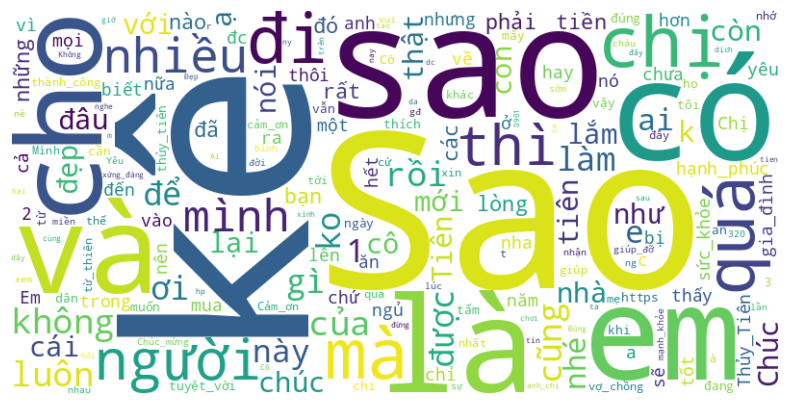

In [30]:

import matplotlib.pyplot as plt
# Hi·ªÉn th·ªã WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### V·∫Ω bi·ªÉu ƒë·ªì

In [31]:
from pyspark.sql.functions import desc
sorted_word_count_df_1 = counts_df.orderBy(desc('count'))
top_20_words_df_1 = sorted_word_count_df_1.limit(20)
top_20_words_pd_1 = top_20_words_df_1.toPandas()

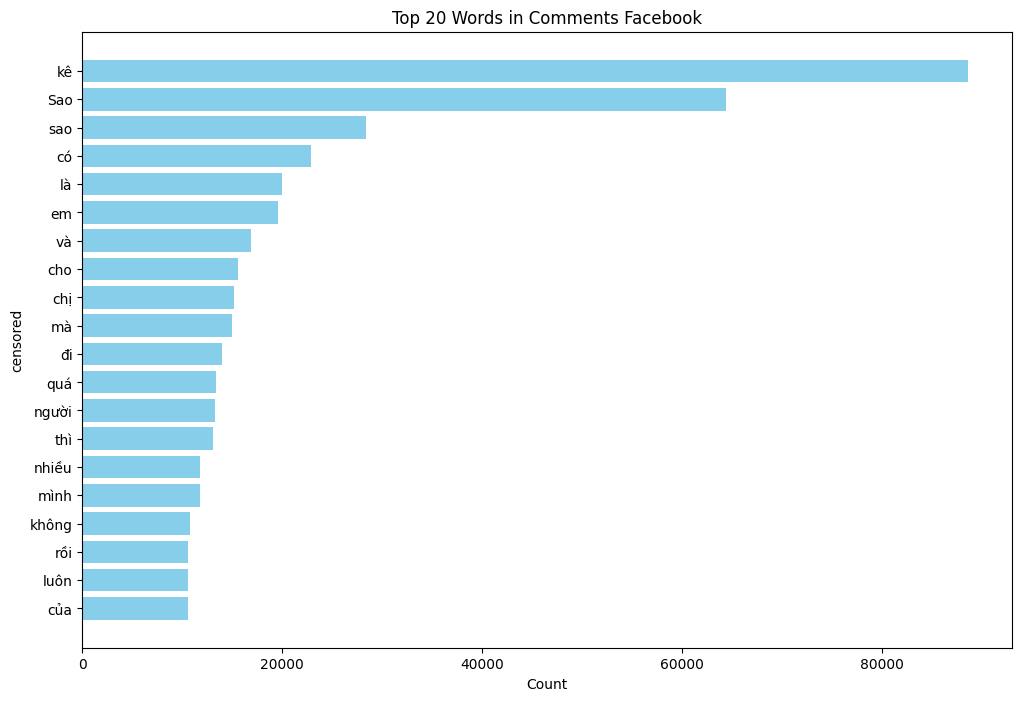

In [32]:
import matplotlib.pyplot as plt
# V·∫Ω bi·ªÉu ƒë·ªì thanh ngang (Bar Chart)
plt.figure(figsize=(12, 8))
plt.barh(top_20_words_pd_1['word'], top_20_words_pd_1['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('censored')
plt.title('Top 20 Words in Comments Facebook')
plt.gca().invert_yaxis()  # ƒê·∫£o ng∆∞·ª£c tr·ª•c y ƒë·ªÉ t·ª´ c√≥ t·∫ßn su·∫•t cao nh·∫•t ·ªü tr√™n c√πng
plt.show()

### T·ªáp comment ƒë√£ x·ª≠ l√Ω Chuy·ªÉn v·ªÅ Dataframe Pyspark

In [33]:
# Chuy·ªÉn ƒë·ªïi textRDD tr·ªü l·∫°i th√†nh DataFrame
# Chia c√°c chu·ªói vƒÉn b·∫£n th√†nh c√°c c·ªôt
rdd_split = textRDD2.map(lambda line: line.split(","))

# X√°c ƒë·ªãnh l∆∞·ª£c ƒë·ªì cho DataFrame m·ªõi (n·∫øu c·∫ßn)
columns = csv_data.columns

# T·∫°o DataFrame t·ª´ rdd_split v·ªõi l∆∞·ª£c ƒë·ªì
new_df = rdd_split.toDF(columns)

In [ ]:
# Hi·ªÉn th·ªã m·ªôt v√†i d√≤ng c·ªßa DataFrame m·ªõi ƒë·ªÉ ki·ªÉm tra
new_df.show(5)

+--------------------+
|            comments|
+--------------------+
|Th∆∞∆°ng ch·ªã Em tin...|
|  Chu·∫©n r·ªìi a tin em|
|End of season sal...|
|Ki·ªán b·∫±ng m·ªçi gi√°...|
|√∫i c√≥ anh ph√≥ng_v...|
+--------------------+
only showing top 5 rows



In [ ]:
new_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comments                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Th∆∞∆°ng ch·ªã Em tin ch·ªã C·∫£m_∆°n ch·ªã Ch√∫c v·ª£_ch·ªìng anh_ch·ªã th·∫≠t nhi·ªÅu s·ª©c_kh·ªèe Nh·ªØng ng∆∞·ªùi ph√°_ho·∫°i h·ªç s·∫Ω b·ªã tr·ª´ng_ph·∫°t th√¥i Tr·∫£ l·∫°i b√¨nh_y√™n cho x√£_h·ªôi                     |
|Chu·∫©n r·ªìi a tin em                                                                                                                                                       |
|End of season sale gi·∫£m 70 anh_em ∆°i                                          

#**Ph√°t hi·ªán b√¨nh lu·∫≠n ti√™u c·ª±c**

## Ph√°t hi·ªán c√°ch 1 (Kh√¥ng ch·∫°y code n√†y)

In [ ]:
# B∆∞·ªõc 1: T·∫°o SparkSession
#spark = SparkSession.builder.appName("DetectNegativeComments").getOrCreate()

# B∆∞·ªõc 2: ƒê·ªçc d·ªØ li·ªáu b√¨nh lu·∫≠n t·ª´ file CSV
#comments_df = spark.read.csv("/content/200k_comments.csv", header=True, encoding="UTF-8")

# B∆∞·ªõc 3: ƒê·ªçc danh s√°ch t·ª´ ng·ªØ ti√™u c·ª±c t·ª´ file TXT
#with open("/content/toxicword.txt", "r", encoding="utf-8") as f:
#    negative_words = f.read().splitlines()

# Chuy·ªÉn ƒë·ªïi danh s√°ch t·ª´ ng·ªØ ti√™u c·ª±c th√†nh regex pattern
#negative_pattern = '|'.join([re.escape(word) for word in negative_words])

# B∆∞·ªõc 4: T·∫°o h√†m UDF ƒë·ªÉ ki·ªÉm tra t·ª´ ng·ªØ ti√™u c·ª±c trong b√¨nh lu·∫≠n
#def get_negative_word(comment):
 #   if comment is None:
  #      return None
   # match = re.search(negative_pattern, comment, re.IGNORECASE)
    #if match:
     #   return match.group(0)
    #return None

# ƒêƒÉng k√Ω UDF
#get_negative_word_udf = udf(get_negative_word, StringType())

# √Åp d·ª•ng UDF ƒë·ªÉ t·∫°o c·ªôt ƒë√°nh d·∫•u b√¨nh lu·∫≠n ti√™u c·ª±c
#comments_df = comments_df.withColumn("negative_word", get_negative_word_udf(col("comments")))

# B∆∞·ªõc 5: B√°o c√°o v√† x√≥a b√¨nh lu·∫≠n ti√™u c·ª±c
# B√°o c√°o
#negative_comments_df = comments_df.filter(col("negative_word").isNotNull()).select("comments", "negative_word")
#negative_comments_df.show(truncate=False)

# X√≥a b√¨nh lu·∫≠n ti√™u c·ª±c
#filtered_comments_df = comments_df.filter(col("negative_word").isNull())

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                                                |negative_word|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Gi√∫p v·∫≠t v·∫≠t tr·∫£ ∆°n gi√∫p ng∆∞·ªùi ng∆∞·ªùi tr·∫£ o√°n.nguoi tin th√¨ r·∫•t th√¥ng c·∫£m c√≤n ng∆∞·ªùi k tin gi·∫£i th√≠ch th·∫ø n√†o ng∆∞·ªùi ta c≈©ng k tin.chang c·∫ßn gi·∫£i th√≠ch l√†m g√¨ cho m·ªát em ∆°i                               |ngu          |
|T·ª•i m√†y t·ªânh t√°o ƒëi. N·∫øu l√† h·ªç b·ªã ƒë√†o m·ªì cu·ªëc m√† c·∫£ 2-3 th√°

In [ ]:
#negative_comments_df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                                                |negative_word|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Gi√∫p v·∫≠t v·∫≠t tr·∫£ ∆°n gi√∫p ng∆∞·ªùi ng∆∞·ªùi tr·∫£ o√°n.nguoi tin th√¨ r·∫•t th√¥ng c·∫£m c√≤n ng∆∞·ªùi k tin gi·∫£i th√≠ch th·∫ø n√†o ng∆∞·ªùi ta c≈©ng k tin.chang c·∫ßn gi·∫£i th√≠ch l√†m g√¨ cho m·ªát em ∆°i                               |ngu          |
|T·ª•i m√†y t·ªânh t√°o ƒëi. N·∫øu l√† h·ªç b·ªã ƒë√†o m·ªì cu·ªëc m√† c·∫£ 2-3 th√°

In [ ]:
# Hi·ªÉn th·ªã c√°c b√¨nh lu·∫≠n kh√¥ng ti√™u c·ª±c c√≤n l·∫°i
#filtered_comments_df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------+
|comments                                                                                                                                                   

## Ph√°t hi·ªán c√°ch 2 (Ch·∫°y code n√†y)

In [34]:
# B∆∞·ªõc 1: T·∫°o SparkSession
#spark3 = SparkSession.builder.appName("DetectNegativeComments").getOrCreate()

# B∆∞·ªõc 2: ƒê·ªçc d·ªØ li·ªáu b√¨nh lu·∫≠n t·ª´ file CSV
#comments_df = spark.read.csv("/content/200k_comments.csv", header=True, encoding="UTF-8")
# B∆∞·ªõc 3: ƒê·ªçc danh s√°ch t·ª´ ng·ªØ ti√™u c·ª±c t·ª´ file TXT
with open("/content/toxicword.txt", "r", encoding="utf-8") as f:
    negative_words = f.read().splitlines()

In [ ]:
negative_words

['# Bu·ªìi, and its variants',
 'bu·ªìi',
 'buoi',
 'dau buoi',
 'daubuoi',
 'caidaubuoi',
 'nhucaidaubuoi',
 'dau boi',
 'b√≤i',
 'dauboi',
 'caidauboi',
 'ƒë·∫ßu b√≤y',
 'ƒë·∫ßu b√πi',
 'dau boy',
 'dauboy',
 'caidauboy',
 'b`',
 '###############################',
 '# C·∫∑c, and its variants',
 'c·∫∑c',
 'cak',
 'kak',
 'kac',
 'cac',
 'concak',
 'nungcak',
 'bucak',
 'caiconcac',
 'caiconcak',
 'cu',
 'c·∫∑k',
 'cak',
 'd√°i',
 'gi√°i',
 'z√°i',
 'kiu',
 '###############################',
 '# C·ª©t, and its variants',
 'c·ª©t',
 'cuccut',
 'cutcut',
 'c·ª©k',
 'cuk',
 'c∆∞·ªùi ·ªâa',
 'c∆∞·ªùi ·∫ª',
 '###############################',
 '# ƒê√©o and its variants',
 'ƒë√©o',
 'ƒë·∫øch',
 'ƒë·∫øk',
 'dek',
 'ƒë·∫øt',
 'ƒë·ªát',
 'ƒë√°ch',
 'dech',
 "ƒë'",
 'deo',
 "d'",
 'ƒëel',
 'ƒë√©l',
 'del',
 'dell ng·ª≠i',
 'dell ngui',
 'dell ch·ªãu',
 'dell chiu',
 'dell hi·ªÉu',
 'dell hieu',
 'dellhieukieugi',
 'dell n√≥i',
 'dell noi',
 'dellnoinhieu',
 'dell bi·∫øt',
 'dell biet',
 'dell ng

In [ ]:
# Sau khi ƒë√£ ti·ªÅn x·ª≠ l√Ω file "/content/200k_comments.csv"
    #csv_data th·ªÉ hi·ªán cho "/content/200k_comments.csv"
    #Ti·ªÅn x·ª≠ l√Ω file csv_data xong ƒë∆∞·ª£c ƒë·∫∑t t√™n m·ªõi l√† new_df (ƒë√¢y l√† DataFrame Pyspark)


In [35]:
# Chuy·ªÉn ƒë·ªïi danh s√°ch t·ª´ ng·ªØ ti√™u c·ª±c th√†nh regex pattern v·ªõi ranh gi·ªõi t·ª´
negative_pattern1 = r'\b(' + '|'.join([re.escape(word) for word in negative_words]) + r')\b'

# B∆∞·ªõc 4: T·∫°o h√†m UDF ƒë·ªÉ ki·ªÉm tra t·ª´ ng·ªØ ti√™u c·ª±c trong b√¨nh lu·∫≠n
def get_negative_word_1(comment):
    if comment is None:
        return None
    match = re.search(negative_pattern1, comment, re.IGNORECASE)
    if match:
        return match.group(0)
    return None

# ƒêƒÉng k√Ω UDF
get_negative_word_udf_1 = udf(get_negative_word_1, StringType())

# √Åp d·ª•ng UDF ƒë·ªÉ t·∫°o c·ªôt ƒë√°nh d·∫•u b√¨nh lu·∫≠n ti√™u c·ª±c
comments_df_1 = new_df.withColumn("negative_word", get_negative_word_udf_1(col("comments")))

In [ ]:
comments_df_1.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                 |negative_word|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Th∆∞∆°ng ch·ªã Em tin ch·ªã C·∫£m_∆°n ch·ªã Ch√∫c v·ª£_ch·ªìng anh_ch·ªã th·∫≠t nhi·ªÅu s·ª©c_kh·ªèe Nh·ªØng ng∆∞·ªùi ph√°_ho·∫°i h·ªç s·∫Ω b·ªã tr·ª´ng_ph·∫°t th√¥i Tr·∫£ l·∫°i b√¨nh_y√™n cho x√£_h·ªôi                     |NULL         |
|Chu·∫©n r·ªìi a tin em                                                                                                                                                       |NULL         |
|End of seas

In [36]:
# B∆∞·ªõc 5: B√°o c√°o v√† x√≥a b√¨nh lu·∫≠n ti√™u c·ª±c
# B√°o c√°o c√°c b√¨nh lu·∫≠n ti√™u c·ª±c
negative_comments_df_1 = comments_df_1.filter(col("negative_word").isNotNull()).select("comments", "negative_word")

In [ ]:
negative_comments_df_1.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                                                 |negative_word|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Ng∆∞·ªùi_ta ƒë√£ kh·ªï_s·ªü ƒëi l√†m t·ª´_thi·ªán Nh·ªØng ng∆∞·ªùi ƒë√≥ng_g√≥p h·ªç ko k√™u g√¨ m·∫•y ng∆∞·ªùi ko ƒë√≥ng_g√≥p th√¨ soi_m√≥i b·ªõi_m√≥c h√£m                                                                                       |h√£m          |
|N√≥i_chuy·ªán th√¨ ph·∫£i v·∫•p ch·ª© tao n√≥i v·ªõi ba m·∫π tao tao c√≤n v·∫•p hu·ªë

In [37]:
# X√≥a c√°c b√¨nh lu·∫≠n ti√™u c·ª±c
filtered_comments_df_1 = comments_df_1.filter(col("negative_word").isNull())

In [ ]:
# Hi·ªÉn th·ªã c√°c b√¨nh lu·∫≠n kh√¥ng ti√™u c·ª±c c√≤n l·∫°i
filtered_comments_df_1.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                 |negative_word|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Th∆∞∆°ng ch·ªã Em tin ch·ªã C·∫£m_∆°n ch·ªã Ch√∫c v·ª£_ch·ªìng anh_ch·ªã th·∫≠t nhi·ªÅu s·ª©c_kh·ªèe Nh·ªØng ng∆∞·ªùi ph√°_ho·∫°i h·ªç s·∫Ω b·ªã tr·ª´ng_ph·∫°t th√¥i Tr·∫£ l·∫°i b√¨nh_y√™n cho x√£_h·ªôi                     |NULL         |
|Chu·∫©n r·ªìi a tin em                                                                                                                                                       |NULL         |
|End of seas

#**Kh√¥ng cho ph√©p ƒëƒÉng b√¨nh lu·∫≠n ti√™u c·ª±c**

In [ ]:
# V√≤ng l·∫∑p y√™u c·∫ßu ng∆∞·ªùi d√πng nh·∫≠p b√¨nh lu·∫≠n
while True:
    user_comment = input("Nh·∫≠p b√¨nh lu·∫≠n c·ªßa b·∫°n (ho·∫∑c nh·∫≠p 'exit' ƒë·ªÉ tho√°t): ")

    if user_comment.lower() == 'exit':
        break

    negative_word = get_negative_word_1(user_comment)

    if negative_word is None:
        print("B√¨nh lu·∫≠n ƒë√£ ƒë∆∞·ª£c ƒëƒÉng nh·∫≠p th√†nh c√¥ng")
    else:
        print("B√¨nh lu·∫≠n c·ªßa b·∫°n ch·ª©a n·ªôi dung ti√™u c·ª±c v√† ƒë√£ b·ªã x√≥a.")

Nh·∫≠p b√¨nh lu·∫≠n c·ªßa b·∫°n (ho·∫∑c nh·∫≠p 'exit' ƒë·ªÉ tho√°t): H√¥m n√†y l√†m c√≥ vui kh√¥ng
B√¨nh lu·∫≠n ƒë√£ ƒë∆∞·ª£c ƒëƒÉng nh·∫≠p th√†nh c√¥ng
Nh·∫≠p b√¨nh lu·∫≠n c·ªßa b·∫°n (ho·∫∑c nh·∫≠p 'exit' ƒë·ªÉ tho√°t): ƒêm h√¥m nay l√† m·ªôt ng√†y t·ªìi t·ªá
Ph√°t hi·ªán b√¨nh lu·∫≠n c√≥ ch∆∞a t·ª´ ng·ªØ ti√™u c·ª±c
Nh·∫≠p b√¨nh lu·∫≠n c·ªßa b·∫°n (ho·∫∑c nh·∫≠p 'exit' ƒë·ªÉ tho√°t): exit


# **TR·ª∞C QUAN H√ìA**

## ƒê·∫øm t·ª´ ng·ªØ ti√™u c·ª±c h∆∞·ªõng [Kh√¥ng ph√¢n bi·ªát ch·ªØ hoa ch·ªØ th∆∞·ªùng]

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#N·∫øu ƒë√£ d·ª´ng Spark th√¨ h√£y kh·ªèi ƒë·ªông l·∫°i b·∫±ng c√¢u l·ªánh b√™n d∆∞·ªõi:

#spark = SparkSession.builder \
#    .appName("ReadCSVExample") \
#    .getOrCreate()

In [39]:
# Chu·∫©n h√≥a d·ªØ li·ªáu: Chuy·ªÉn t·∫•t c·∫£ c√°c t·ª´ trong c·ªôt 'negative_word' v·ªÅ ch·ªØ vi·∫øt th∆∞·ªùng
negative_comments_df_3 = negative_comments_df_1.withColumn('negative_word', lower(negative_comments_df_1['negative_word']))

In [40]:
# T√°ch c√°c t·ª´ trong c·ªôt 'negative_word' v√† ƒë·∫øm t·∫ßn su·∫•t
words_df_1 = negative_comments_df_3.select(explode(split('negative_word', ' ')).alias('word'))

In [41]:
# ƒê·∫øm t·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa t·ª´ng t·ª´
word_count_df_1 = words_df_1.groupBy('word').count()
word_count_df_1 = word_count_df_1.orderBy('count', ascending=False)

In [ ]:
word_count_df_1.show()

+-----+-----+
| word|count|
+-----+-----+
|  ƒë√©o| 1054|
|  ngu|  581|
|   cu|  281|
|   vl|  260|
|   ƒëm|  235|
|   m·∫π|  188|
|  v√£i|  152|
|   cl|  149|
|   dm|  129|
|  cac|  128|
|   k·ªá|  105|
|  vcl|  101|
|  deo|   80|
|  h√£m|   73|
|  lol|   70|
| ch·∫øt|   69|
|ch·ªãch|   65|
|   ƒëƒ©|   64|
|  cmn|   63|
|  sml|   51|
+-----+-----+
only showing top 20 rows



In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace

# Kh·ªüi t·∫°o SparkSession
spark1 = SparkSession.builder.appName("WordCensorship").getOrCreate()

# D·ªØ li·ªáu m·∫´u
data = word_count_df_1

# H√†m ƒë·ªÉ l√†m m·ªù t·ª´
# H√†m ƒë·ªÉ l√†m m·ªù t·ª´
def censor_word(word):
    if len(word) == 2:
        return word[0] + "*"
    elif len(word) >= 3:
        return word[0] + "*" * (len(word) - 2) + word[-1]
    else:
        return word

# UDF ƒë·ªÉ √°p d·ª•ng h√†m censor_word
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

censor_word_udf = udf(censor_word, StringType())

# √Åp d·ª•ng h√†m l√†m m·ªù t·ª´ v√†o c·ªôt "word"
censored_df = word_count_df_1.withColumn("censored_word", censor_word_udf(col("word")))

In [ ]:
# Hi·ªÉn th·ªã k·∫øt qu·∫£
censored_df.show()

+-----+-----+-------------+
| word|count|censored_word|
+-----+-----+-------------+
|  ƒë√©o| 1054|          ƒë*o|
|  ngu|  581|          n*u|
|   cu|  281|           c*|
|   vl|  260|           v*|
|   ƒëm|  235|           ƒë*|
|   m·∫π|  188|           m*|
|  v√£i|  152|          v*i|
|   cl|  149|           c*|
|   dm|  129|           d*|
|  cac|  128|          c*c|
|   k·ªá|  105|           k*|
|  vcl|  101|          v*l|
|  deo|   80|          d*o|
|  h√£m|   73|          h*m|
|  lol|   70|          l*l|
| ch·∫øt|   69|         c**t|
|ch·ªãch|   65|        c***h|
|   ƒëƒ©|   64|           ƒë*|
|  cmn|   63|          c*n|
|  sml|   51|          s*l|
+-----+-----+-------------+
only showing top 20 rows



In [43]:
# L·∫•y hai c·ªôt "censored_word" v√† "count"
result_df = censored_df.select(col("censored_word").alias("censored"), col("count"))

In [ ]:
# Hi·ªÉn th·ªã k·∫øt qu·∫£
result_df.show(truncate=False)

+--------+-----+
|censored|count|
+--------+-----+
|ƒë*o     |1054 |
|n*u     |581  |
|c*      |281  |
|v*      |260  |
|ƒë*      |235  |
|m*      |188  |
|v*i     |152  |
|c*      |149  |
|d*      |129  |
|c*c     |128  |
|k*      |105  |
|v*l     |101  |
|d*o     |80   |
|h*m     |73   |
|l*l     |70   |
|c**t    |69   |
|c***h   |65   |
|ƒë*      |64   |
|c*n     |63   |
|s*l     |51   |
+--------+-----+
only showing top 20 rows



In [44]:
# Chuy·ªÉn ƒë·ªïi DataFrame t·ª´ PySpark sang Pandas
pandas_df = result_df.toPandas()

In [45]:
# Chuy·ªÉn ƒë·ªïi k·∫øt qu·∫£ v·ªÅ Pandas DataFrame
word_count_pd = word_count_df_1.toPandas()

In [46]:
# T·∫°o t·ª´ ƒëi·ªÉn t·∫ßn su·∫•t t·ª´
word_freq1 = dict(zip(pandas_df ['censored'], pandas_df ['count']))

In [47]:
# T·∫°o WordCloud
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq1)


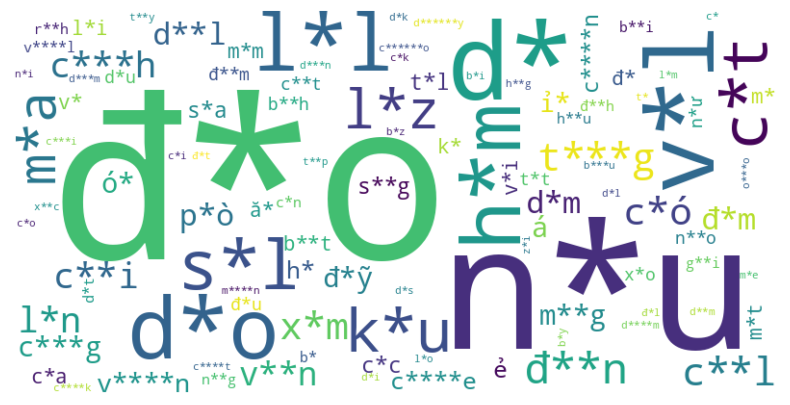

In [48]:
# Hi·ªÉn th·ªã WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()

## Bi·ªÉu ƒë·ªì tr·ª±c quan h√≥a

### S·∫Øp x·∫øp theo top 20 t·ª´

In [49]:
from pyspark.sql.functions import desc

In [50]:
# S·∫Øp x·∫øp DataFrame theo c·ªôt 'count' theo th·ª© t·ª± gi·∫£m d·∫ßn
sorted_word_count_df = result_df.orderBy(desc('count'))

# L·∫•y top 20 t·ª´
top_20_words_df = sorted_word_count_df.limit(20)


In [ ]:
# Hi·ªÉn th·ªã k·∫øt qu·∫£
top_20_words_df.show()

+--------+-----+
|censored|count|
+--------+-----+
|     ƒë*o| 1054|
|     n*u|  581|
|      c*|  281|
|      v*|  260|
|      ƒë*|  235|
|      m*|  188|
|     v*i|  152|
|      c*|  149|
|      d*|  129|
|     c*c|  128|
|      k*|  105|
|     v*l|  101|
|     d*o|   80|
|     h*m|   73|
|     l*l|   70|
|    c**t|   69|
|   c***h|   65|
|      ƒë*|   64|
|     c*n|   63|
|     s*l|   51|
+--------+-----+



In [ ]:
sorted_word_count_df.show()

+--------+-----+
|censored|count|
+--------+-----+
|     ƒë*o| 1054|
|     n*u|  581|
|      c*|  281|
|      v*|  260|
|      ƒë*|  235|
|      m*|  188|
|     v*i|  152|
|      c*|  149|
|      d*|  129|
|     c*c|  128|
|      k*|  105|
|     v*l|  101|
|     d*o|   80|
|     h*m|   73|
|     l*l|   70|
|    c**t|   69|
|   c***h|   65|
|      ƒë*|   64|
|     c*n|   63|
|     s*l|   51|
+--------+-----+
only showing top 20 rows



N·∫øu d√πng dataframe t·ª´ th∆∞ vi·ªán Pandas

In [51]:
import pandas as pd

In [52]:
top_20_words_pd = top_20_words_df.toPandas()

In [ ]:
print(top_20_words_pd)

   censored  count
0       ƒë*o   1054
1       n*u    581
2        c*    281
3        v*    260
4        ƒë*    235
5        m*    188
6       v*i    152
7        c*    149
8        d*    129
9       c*c    128
10       k*    105
11      v*l    101
12      d*o     80
13      h*m     73
14      l*l     70
15     c**t     69
16    c***h     65
17       ƒë*     64
18      c*n     63
19      s*l     51


In [53]:
All_negative_words=sorted_word_count_df.toPandas()

In [54]:
All_negative_words.head()

censored  count
0      ƒë*o   1054
1      n*u    581
2       c*    281
3       v*    260
4       ƒë*    235

### Bi·ªÉu ƒë·ªì

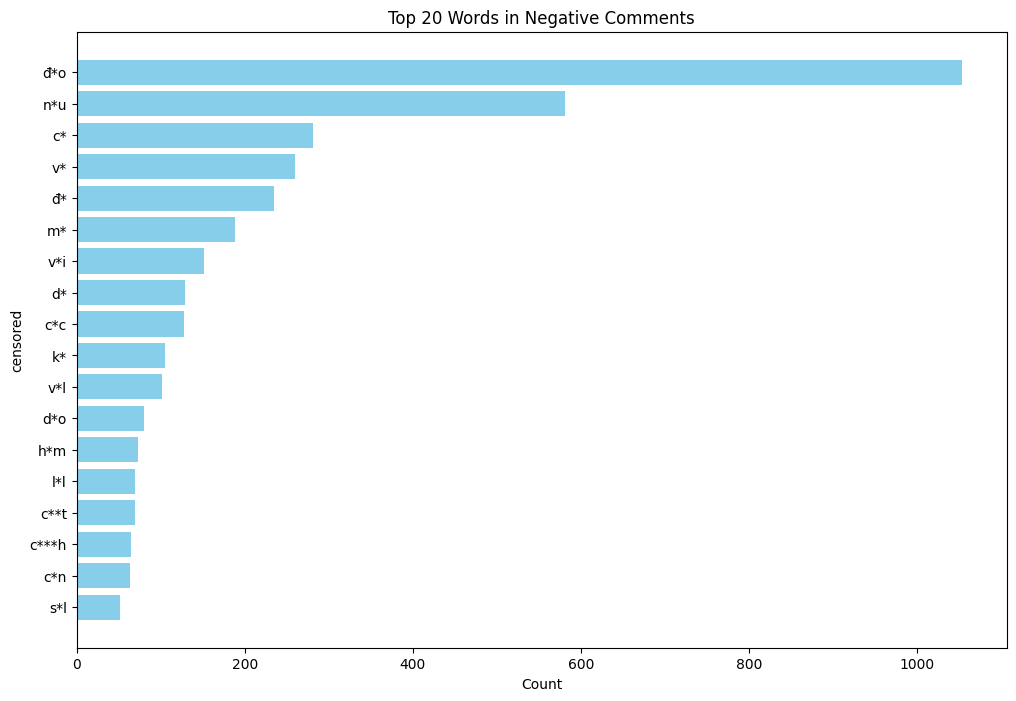

In [55]:
import matplotlib.pyplot as plt
# V·∫Ω bi·ªÉu ƒë·ªì thanh ngang (Bar Chart)
plt.figure(figsize=(12, 8))
plt.barh(top_20_words_pd['censored'], top_20_words_pd['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('censored')
plt.title('Top 20 Words in Negative Comments')
plt.gca().invert_yaxis()  # ƒê·∫£o ng∆∞·ª£c tr·ª•c y ƒë·ªÉ t·ª´ c√≥ t·∫ßn su·∫•t cao nh·∫•t ·ªü tr√™n c√πng
plt.show()

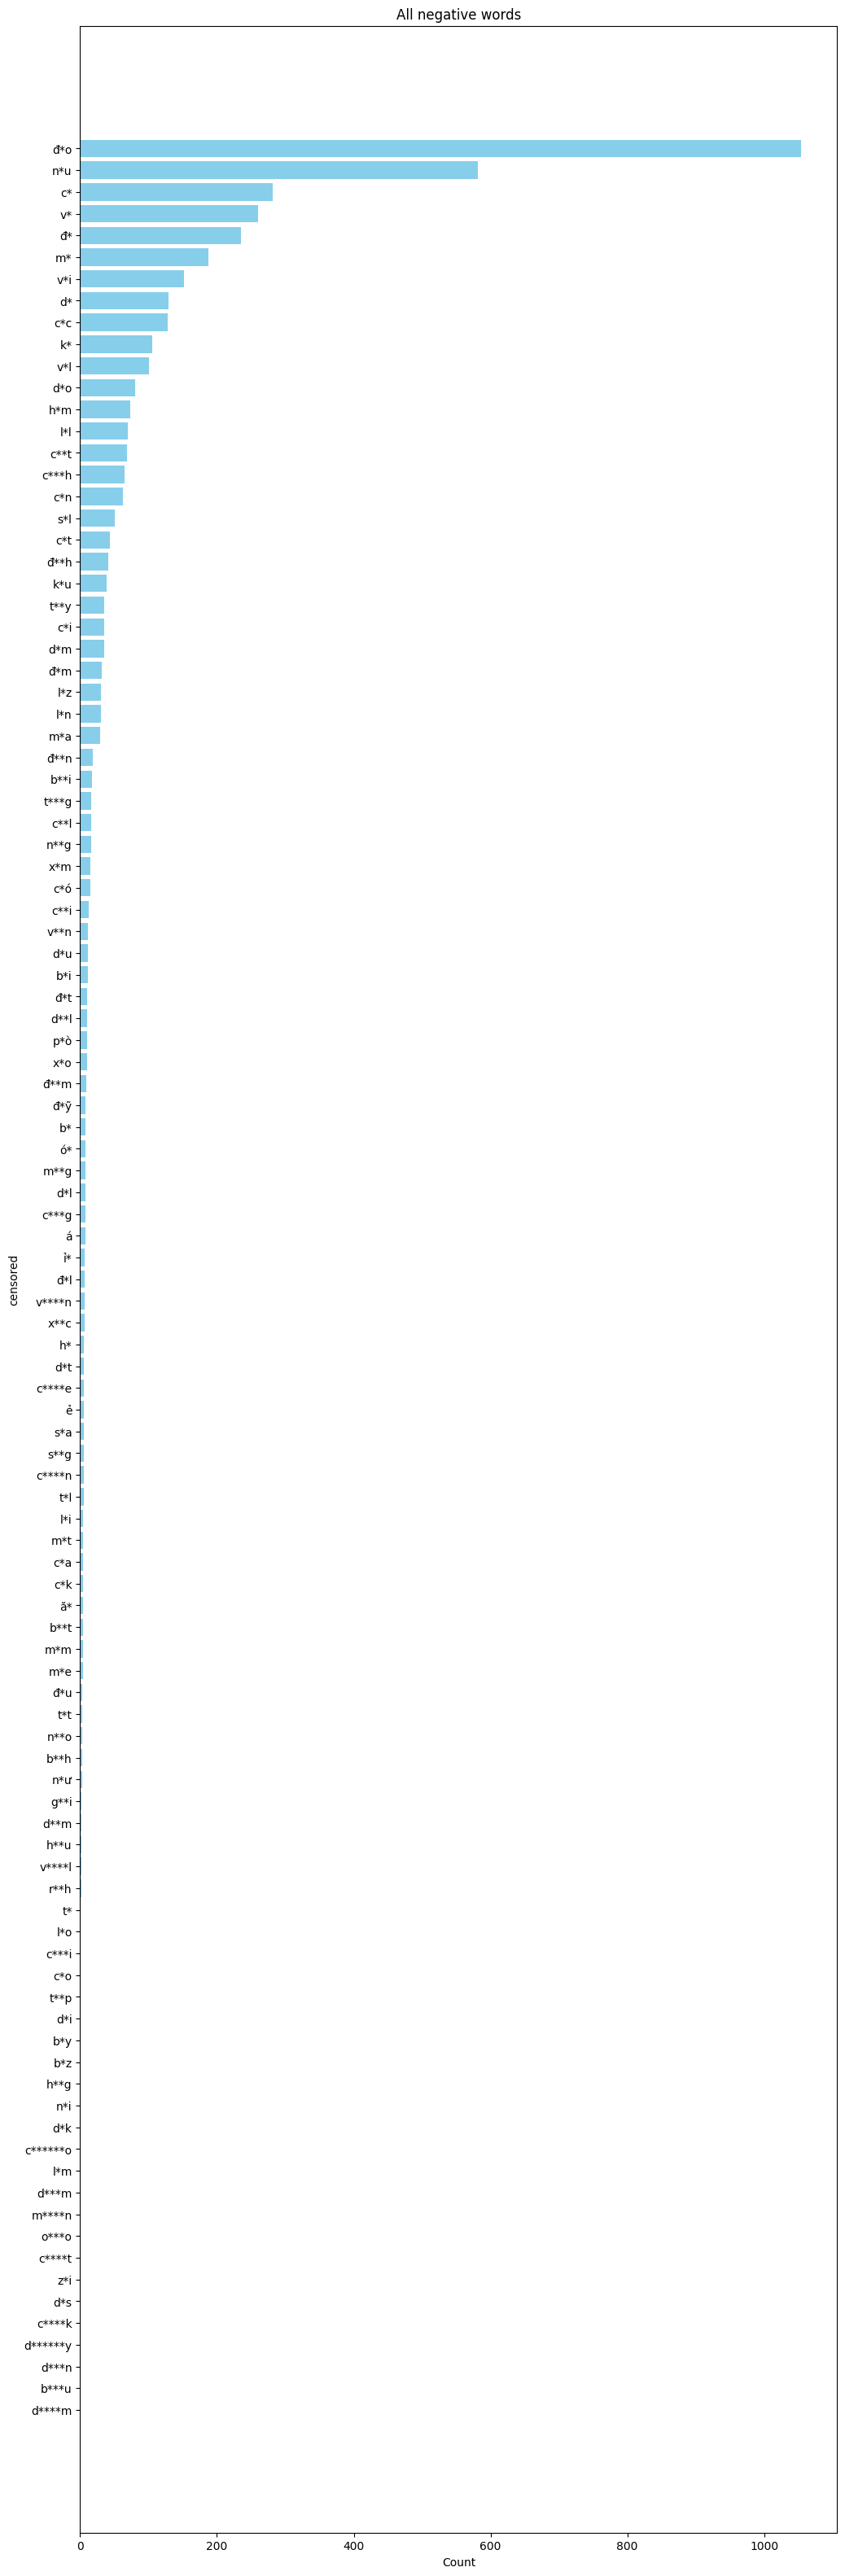

In [58]:
import matplotlib.pyplot as plt
# V·∫Ω bi·ªÉu ƒë·ªì thanh ngang (Bar Chart)
plt.figure(figsize=(12, 40))
plt.barh(All_negative_words['censored'], All_negative_words['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('censored')
plt.title('All negative words')
plt.gca().invert_yaxis()  # ƒê·∫£o ng∆∞·ª£c tr·ª•c y ƒë·ªÉ t·ª´ c√≥ t·∫ßn su·∫•t cao nh·∫•t ·ªü tr√™n c√πng
plt.show()

In [ ]:
#S·ª≠ d·ª•ng dataframe : Pie Chart

import altair as alt
chart = alt.Chart(All_negative_words).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="censored", type="nominal"),
).properties(
    width=500,
    height=300,
)
chart


alt.Chart(...)

In [ ]:
#S·ª≠ d·ª•ng dataframe top_20_words_pd: Pie Chart

import altair as alt
chart = alt.Chart(top_20_words_pd).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="censored", type="nominal"),
).properties(
    width=500,
    height=300,
)
chart


alt.Chart(...)

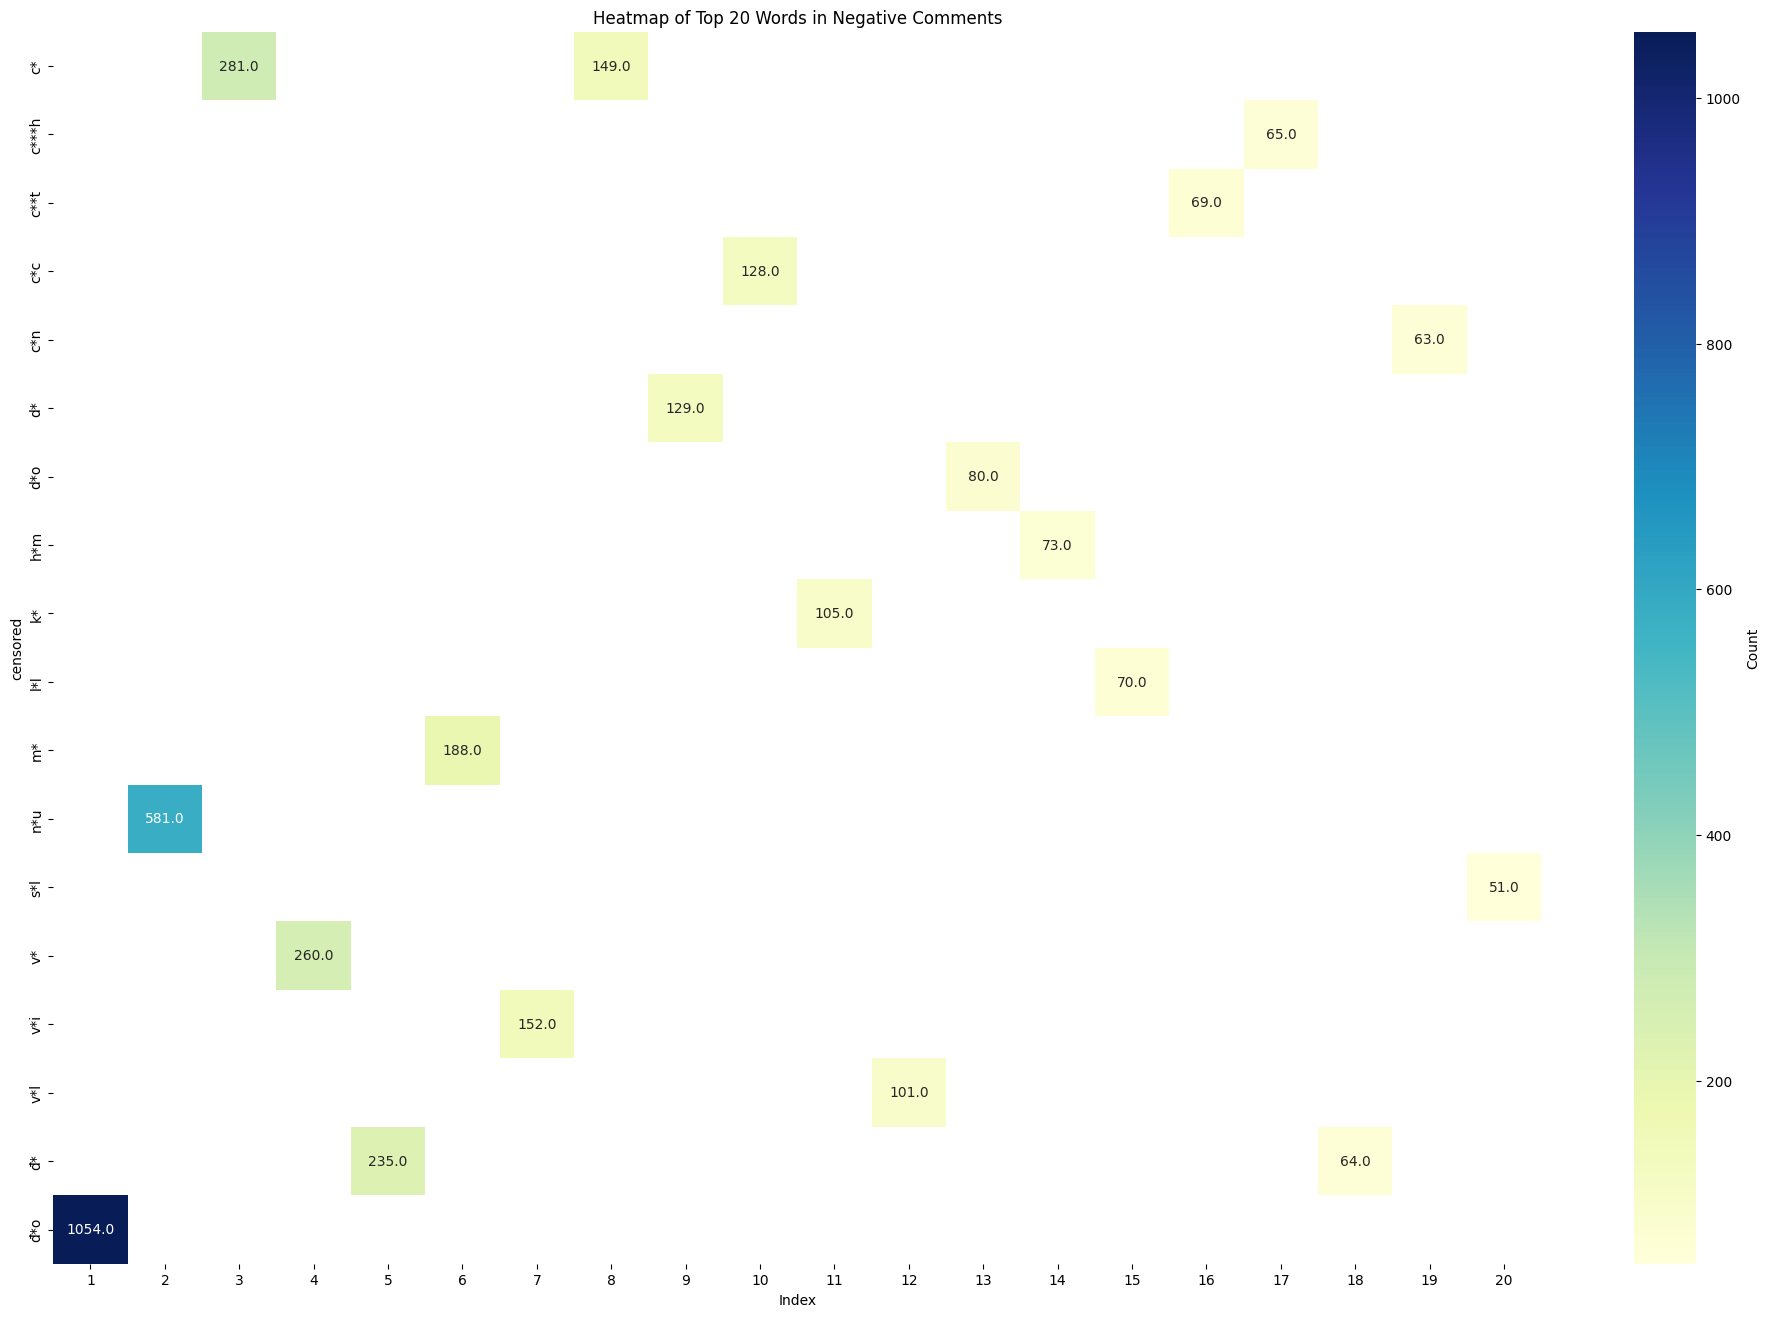

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# T·∫°o m·ªôt tr·ª•c x gi·∫£ ƒë·ªÉ t·∫°o heatmap
top_20_words_pd['index'] = range(1, len(top_20_words_pd) + 1)
# T·∫°o m·ªôt Pivot Table ƒë·ªÉ d√πng cho heatmap
heatmap_data = pd.pivot_table(top_20_words_pd, values='count', index='censored', columns='index')
# V·∫Ω heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Heatmap of Top 20 Words in Negative Comments')
plt.xlabel('Index')
plt.ylabel('censored')
plt.show()

# **D·ª™NG SPARK**

In [ ]:
# D·ª´ng SparkSession
spark.stop()

In [ ]:
spark1.stop()